In [1]:
import sys
sys.path.append("../")

from smc.utils import load_pima_indians_data, log_weights_to_weights, effective_sample_size, \
    ProgressBar, gaussian_kernel
from models.samplers.normal import NormalSampler

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook I consider of sampling from a $N(0, \Sigma)$ in $\mathcal{R}^{10}$ beginning from a $N(0, \Sigma \cdot 250)$. We consider the following sampling methods

- Direct sampling (for comparison)
- Sequential Monte Carlo
- SMC with adaptive resampling
- Annealed importance sampling (no resampling)
- Multilevel sampling (no weights, no resampling)

We use each method to draw 100 samples from the target distribution. We evaluate the efficacy of each sampling method by computing the KL divergence between the target distribution and the normal distribution constructed using the empirical mean and covariance. We consider the following parameter settings

- Number of steps: 5, 10, 15
- Number of gibbs scans per step: 2, 6
- Path selection: Linear, $L_2$ optimal, and adaptive

We perform 250 simulations for each sampling method using each parameter setting

In [2]:
np.random.seed(1337)
D = 10
mean = np.zeros(D)
cov = stats.wishart(df = 2*D, scale =np.eye(D)).rvs(1)
normal_smc = NormalSampler(mean, cov)

Loading Stan model...


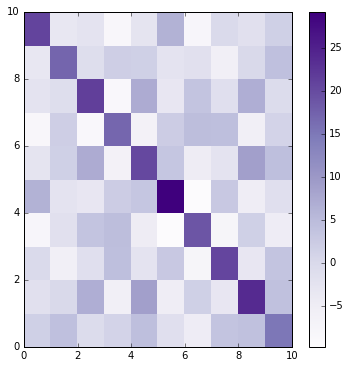

In [3]:
plt.rcParams['figure.figsize'] = 6, 6
plt.pcolor(cov[::-1],cmap='Purples')
plt.colorbar()
plt.show()

In [4]:
path_lens = [5, 10, 15]
steps = [2, 6]
N = 100
iters = 250
beta0 = 0.004

## Linear path

In [5]:
results = {}
methods = ['smc', 'adaptive_smc', 'ais', 'multilevel_mcmc']
pb = ProgressBar(iters*len(methods)*len(path_lens)*len(steps))

for path_len in path_lens:
    for step in steps:

        # init the path
        path = [(beta,) for beta in np.linspace(beta0,1,path_len+1)]

        # init this dict
        results[(path_len, step)] = {}
        for method in methods:
            results[(path_len, step)][method]=[]

        for i in range(iters):   

            # loop through the methods
            for method in methods:

                # sample and estimate
                output = normal_smc.sampling(path, N, method=method, 
                                             save_all_samples=False, smc_kwargs={'kernel_steps':step}, verbose=False)
                # weights = log_weights_to_weights(output[1])
                # mse = ((output[0]*weights[:, None]).sum(0)**2).mean() 
                kl = normal_smc._compute_kl_divergence(output[0], output[1])
                
                # record stuff
                #results[(path_len, step)][method].append(mse)    
                results[(path_len, step)][method].append(kl)    
                pb.increment()
        
pb.finish()

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 
Elapsed time: 12008.4 seconds.


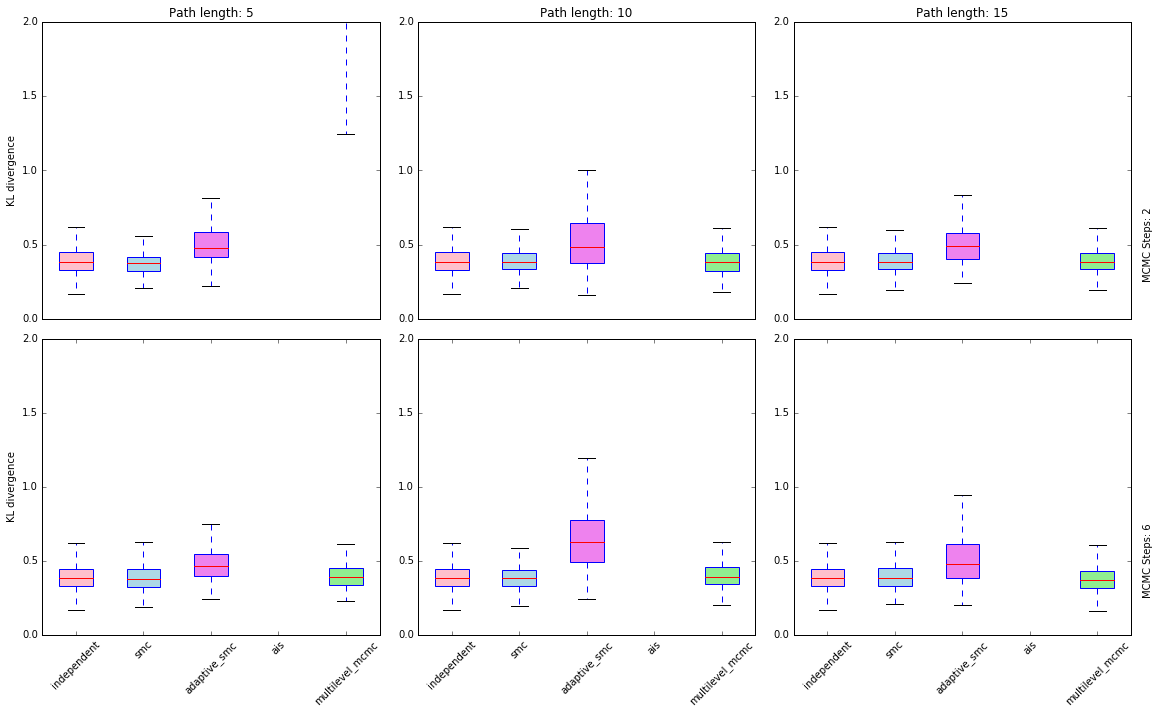

In [7]:
i = 0
plt.rcParams['figure.figsize'] = 16, 10
colors = ['pink', 'lightblue', 'violet', 'red', 'lightgreen']

# fake an mcmc estimate
samples = stats.multivariate_normal(mean=normal_smc.mean, cov=normal_smc.covariance).rvs((1000,N))
log_weights = np.zeros(N).astype('float')
independent = [normal_smc._compute_kl_divergence(sample, log_weights) for sample in samples]

for row, step in enumerate(steps):
    for col, path_len in enumerate(path_lens):

        # fake an mcmc estimate
        numbers = [independent]        
        numbers+= [results[(path_len, step)][method] for method in methods]
        
        i+=1
        plt.subplot(len(steps), len(path_lens), i)
        
        # set colors
        bplot = plt.boxplot(numbers, patch_artist=True, showfliers=False)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        
        plt.ylim(0, 2.0)
        #plt.xticks(range(1,len(methods)+1), methods, rotation=45)
        plt.xticks([], [])
        
        if row==0:
            plt.title('Path length: {}'.format(path_len))            
                    
        if col==0:
            plt.ylabel('KL divergence')
            
        if row==(len(steps)-1):
            plt.xticks(range(1,len(methods)+2), ['independent']+methods, rotation=45)
        
        if col==(len(path_lens)-1):
            plt.text(5.75, 0.5, 'MCMC Steps: {}'.format(step),
                     horizontalalignment='center',
                     verticalalignment='center',
                     rotation='vertical')
            
plt.tight_layout()
plt.savefig('plots/multilevel_normal/normal_comparison_linear_path.png')
plt.show()

## Optimal Path

Some path lengths and associated c's

In [5]:
def get_optimal_path(path_len, D, beta0, lower=0, upper=10**6):
    """uses an optimization routine to find the optimal route,
    because its a discrete programming problem . path_len should be bigger than 2 for this to be coherent"""
    
    from scipy.optimize import brentq
    target = np.exp(np.log(1.0/beta0)/(path_len-1.0)) - 1.0
    delta = lambda c: c/D + (c**2/D**2 + c/D)**0.5 - target
    
    c = brentq(delta, lower, upper)    
    delta = c/D + (c**2/D**2 + c/D)**0.5 
    path = beta0*(1.0+delta)**np.arange(path_len)
    
    return path

In [6]:
results = {}
methods = ['smc', 'adaptive_smc', 'ais', 'multilevel_mcmc']
pb = ProgressBar(iters*len(methods)*len(path_lens)*len(steps))

for path_len in path_lens:
    for step in steps:

        # init the path
        path = get_optimal_path(path_len, D, beta0)
        path = [(beta,) for beta in path]

        # init this dict
        results[(path_len, step)] = {}
        for method in methods:
            results[(path_len, step)][method]=[]

        for i in range(iters):   

            # loop through the methods
            for method in methods:

                # sample and estimate
                output = normal_smc.sampling(path, N, method=method, 
                                             save_all_samples=False, smc_kwargs={'kernel_steps':step}, verbose=False)
                kl = normal_smc._compute_kl_divergence(output[0], output[1])
                   
                results[(path_len, step)][method].append(kl)    
                pb.increment()
        
pb.finish()

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 
Elapsed time: 7805.7 seconds.


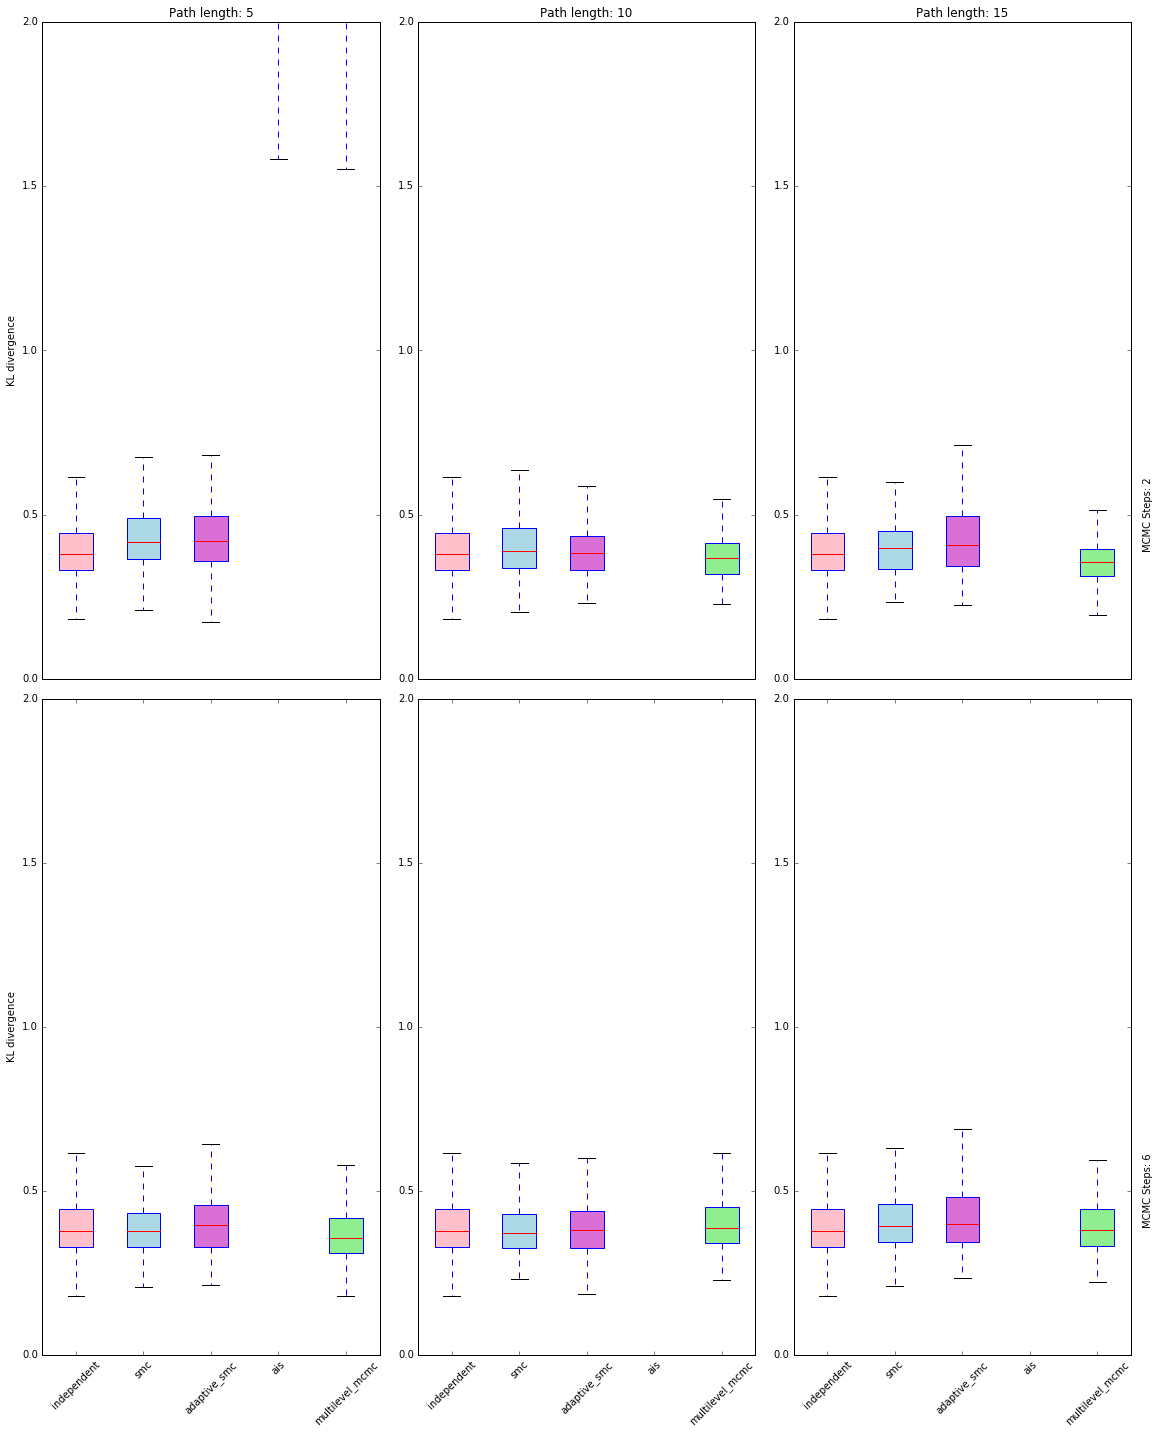

In [7]:
i = 0
plt.rcParams['figure.figsize'] = 16, 20
colors = ['pink', 'lightblue', 'orchid', 'red', 'lightgreen']

# fake an mcmc estimate
samples = stats.multivariate_normal(mean=normal_smc.mean, cov=normal_smc.covariance).rvs((1000,N))
log_weights = np.zeros(N).astype('float')
independent = [normal_smc._compute_kl_divergence(sample, log_weights) for sample in samples]

for row, step in enumerate(steps):
    for col, path_len in enumerate(path_lens):

        # fake an mcmc estimate
        numbers = [independent]        
        numbers+= [results[(path_len, step)][method] for method in methods]
        
        i+=1
        plt.subplot(len(steps), len(path_lens), i)
        
        # set colors
        bplot = plt.boxplot(numbers, patch_artist=True, showfliers=False)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        
        plt.ylim(0, 2.0)
        
        #plt.xticks(range(1,len(methods)+1), methods, rotation=45)
        plt.xticks([], [])
        
        if row==0:
            plt.title('Path length: {}'.format(path_len))            
                    
        if col==0:
            plt.ylabel('KL divergence')
            
        if row==(len(steps)-1):
            plt.xticks(range(1,len(methods)+2), ['independent']+methods, rotation=45)
        
        if col==(len(path_lens)-1):
            plt.text(5.75, 0.5, 'MCMC Steps: {}'.format(step),
                     horizontalalignment='center',
                     verticalalignment='center',
                     rotation='vertical')
            
plt.tight_layout()
plt.savefig('plots/multilevel_normal/normal_comparison_optimal_path.png')
plt.show()

## Adaptive Path

In [8]:
def get_target_ess(path_len, D, beta0, lower=0, upper=10**6):
    """uses an optimization routine to find the optimal route,
    because its a discrete programming problem . path_len should be bigger than 2 for this to be coherent"""
    
    from scipy.optimize import brentq
    target = np.exp(np.log(1.0/beta0)/(path_len-1.0)) - 1.0
    delta = lambda c: c/D + (c**2/D**2 + c/D)**0.5 - target
    
    c = brentq(delta, lower, upper) 
    
    return 1.0/np.exp(c/2)

In [9]:
results = {}
paths = {}
methods = ['smc', 'adaptive_smc', 'ais', 'multilevel_mcmc']
pb = ProgressBar(iters*len(methods)*len(path_lens)*len(steps))

target_ess = [0.9, 0.5]
adaptive_path_lens = []
        
for path_len in path_lens:
    for step in steps:

        # init this dict
        results[(path_len, step)] = {}        
        for method in methods:
            results[(path_len, step)][method]=[]
            
        # save the paths cause why not
        paths[(path_len, step)] = {}
        for method in methods:
            paths[(path_len, step)][method]=[]
            
        # make a guess at the target ess
        ess = get_target_ess(path_len, normal_smc.mean.shape[0], beta0)

        for i in range(iters):   

            # loop through the methods
            for method in methods:

                # sample and estimate
                output = normal_smc.adaptive_sampling(N, 
                                                      ess, 
                                                      method=method, 
                                                      save_all_samples=False, 
                                                      smc_kwargs={'kernel_steps':step}, 
                                                      verbose=False, beta0=beta0)
                
                kl = normal_smc._compute_kl_divergence(output[0], output[1])
                  
                results[(path_len, step)][method].append(kl) 
                paths[(path_len, step)][method].append(np.array(output[-1])) 
                pb.increment()
        
pb.finish()

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 
Elapsed time: 7551.2 seconds.


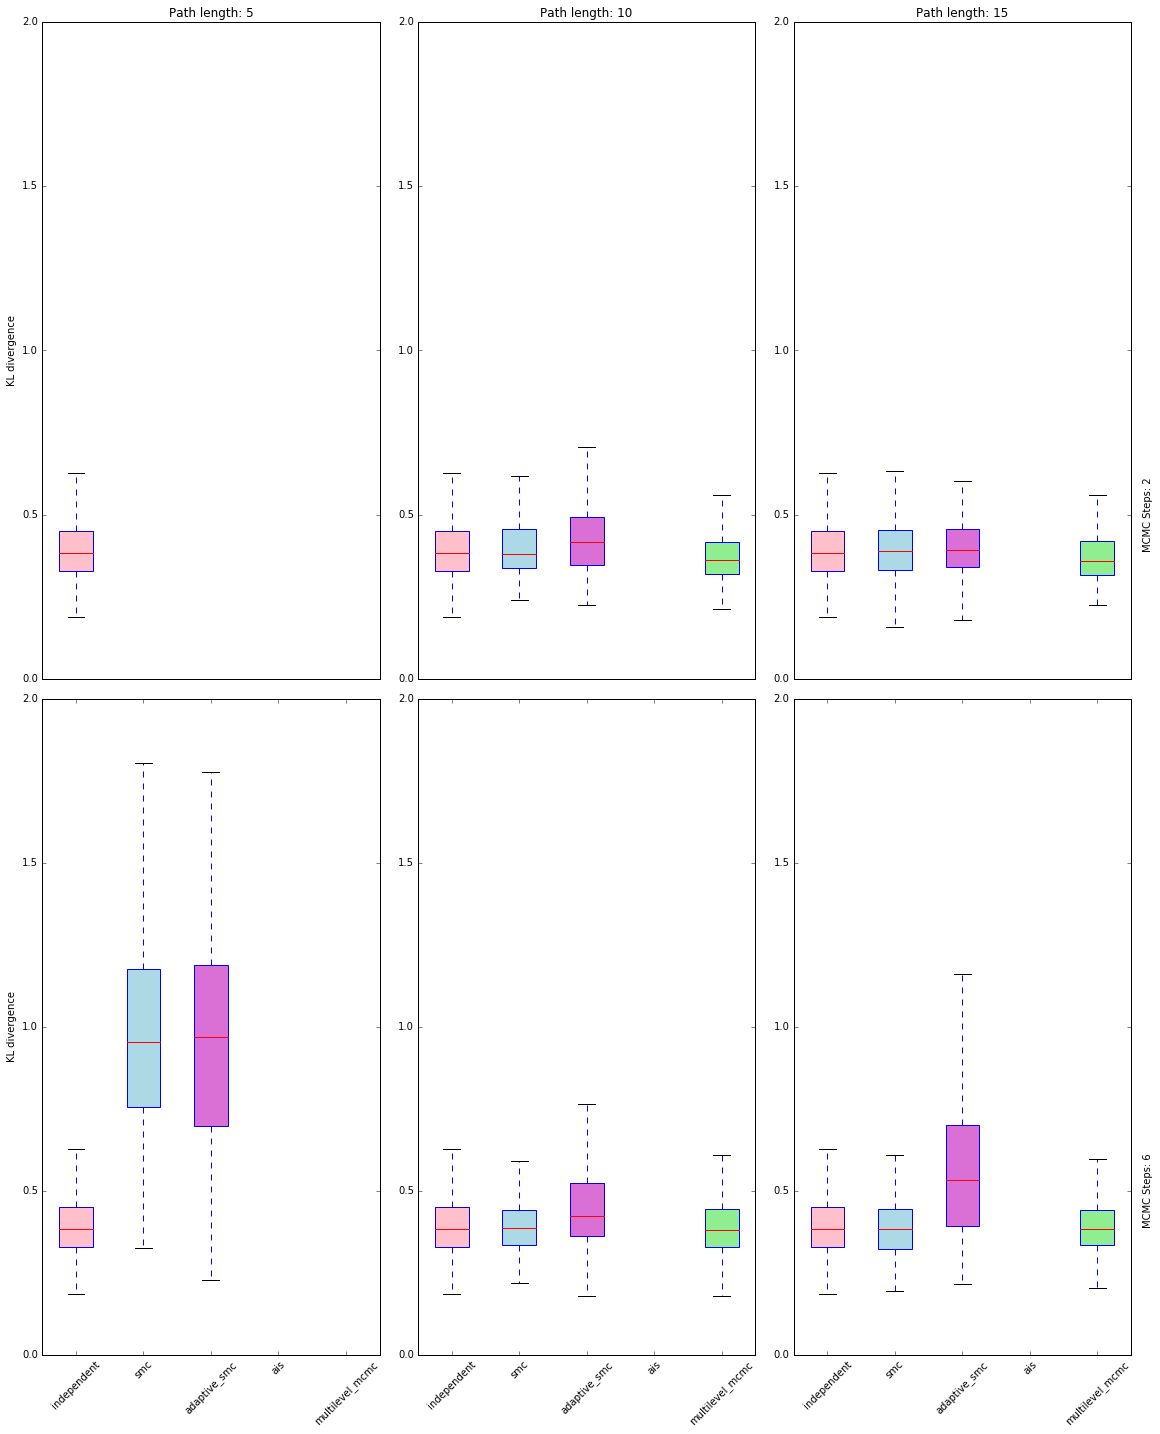

In [10]:
i = 0
plt.rcParams['figure.figsize'] = 16, 20
colors = ['pink', 'lightblue', 'orchid', 'red', 'lightgreen']

# fake an mcmc estimate
samples = stats.multivariate_normal(mean=normal_smc.mean, cov=normal_smc.covariance).rvs((1000,N))
log_weights = np.zeros(N).astype('float')
independent = [normal_smc._compute_kl_divergence(sample, log_weights) for sample in samples]

for row, step in enumerate(steps):
    for col, path_len in enumerate(path_lens):

        # fake an mcmc estimate
        numbers = [independent]        
        numbers+= [results[(path_len, step)][method] for method in methods]
        
        i+=1
        plt.subplot(len(steps), len(path_lens), i)
        
        # set colors
        bplot = plt.boxplot(numbers, patch_artist=True, showfliers=False)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        
        plt.ylim(0, 2.0)
        #plt.xticks(range(1,len(methods)+1), methods, rotation=45)
        plt.xticks([], [])
        
        if row==0:
            plt.title('Path length: {}'.format(path_len))
            
        if col==0:
            plt.ylabel('KL divergence')
            
        if row==(len(steps)-1):
            plt.xticks(range(1,len(methods)+2), ['independent']+methods, rotation=45)
        
        if col==(len(path_lens)-1):
            plt.text(5.75, 0.5, 'MCMC Steps: {}'.format(step),
                     horizontalalignment='center',
                     verticalalignment='center',
                     rotation='vertical')
            
plt.tight_layout()
plt.savefig('plots/multilevel_normal/normal_comparison_adaptive_path.png')
plt.show()

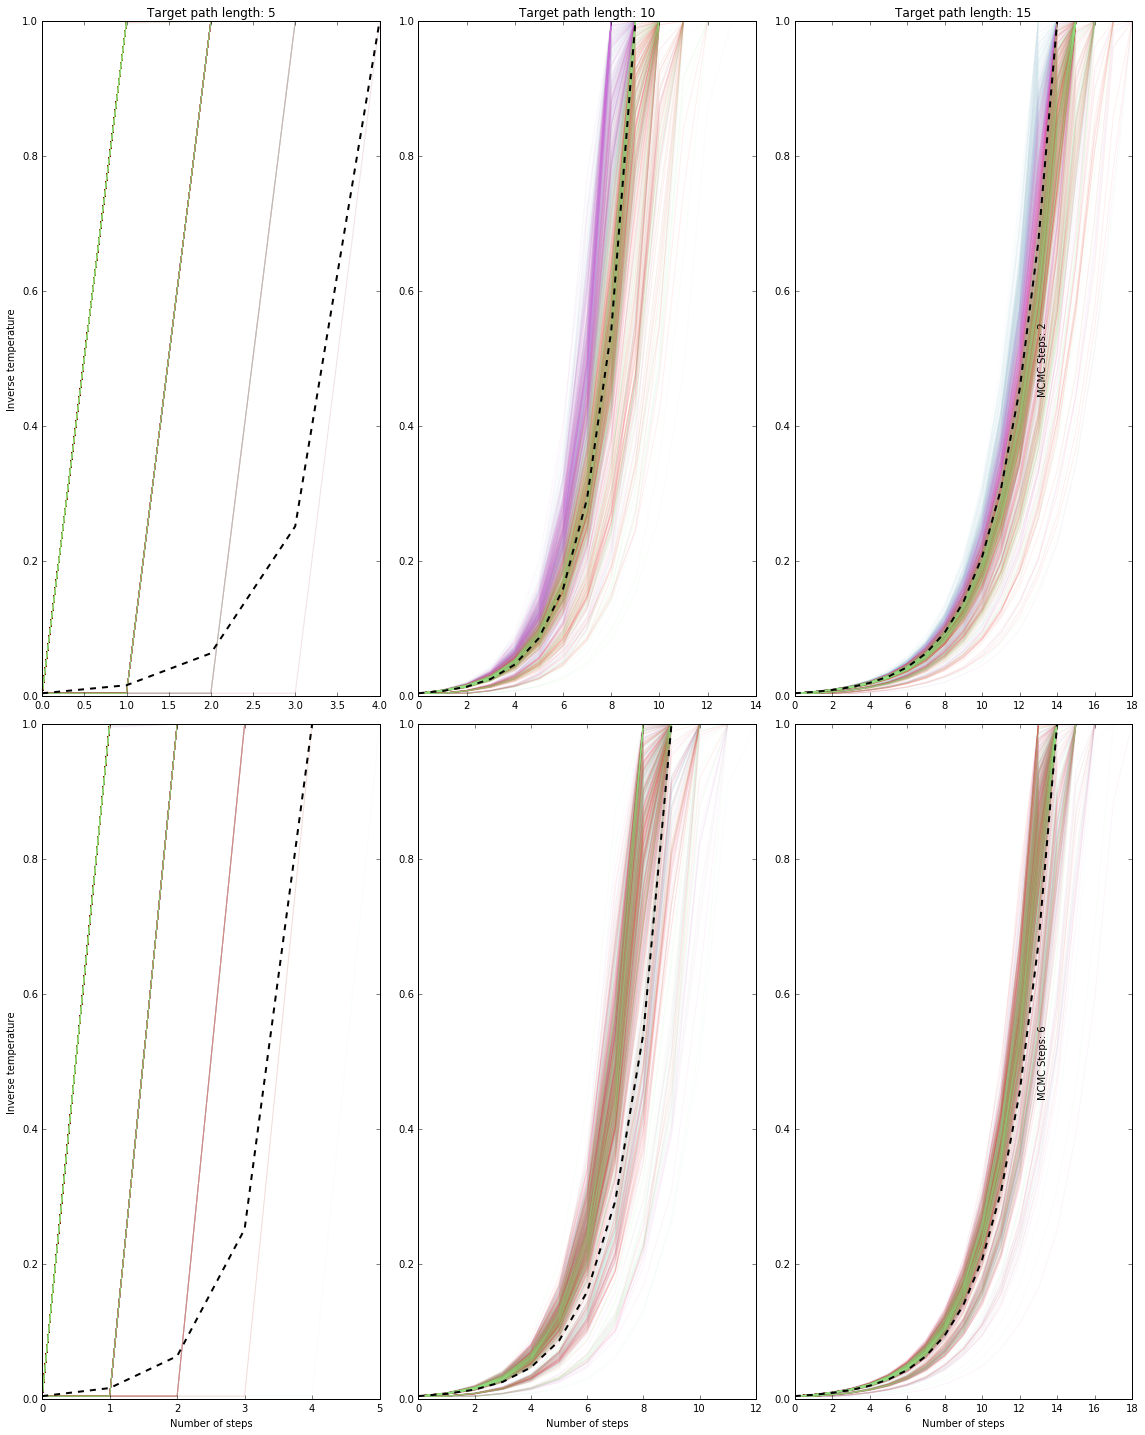

In [11]:
i = 0
colors = ['lightblue', 'orchid', 'red', 'lightgreen']
for row, step in enumerate(steps):
    for col, path_len in enumerate(path_lens):

        # fake an mcmc estimate       
        i+=1
        plt.subplot(len(steps), len(path_lens), i)
        
        for color, method in zip(colors, methods):
            for path in paths[(path_len, step)][method]:
                plt.plot(path, color=color, alpha=1.0/iters**0.5)
        plt.plot(get_optimal_path(path_len, D, beta0), color='k', lw=2, ls='--')
        
        plt.ylim(0, 1.0)
        
        
        if row==0:
            plt.title('Target path length: {}'.format(path_len))
            
        if col==0:
            plt.ylabel('Inverse temperature')
            
        if row==(len(steps)-1):
            plt.xlabel('Number of steps')
            
        if col==(len(path_lens)-1):
            plt.text(path_lens[-1]-1.75, 0.5, 'MCMC Steps: {}'.format(step),
                     horizontalalignment='center',
                     verticalalignment='center',
                     rotation='vertical')
            
plt.tight_layout()
plt.savefig('plots/multilevel_normal/normal_comparison_adaptive_path_comparison.png')
plt.show()